In [102]:
#Pkg.update()
#Pkg.add("Distributions")
#Pkg.add("LightGraphs")
#Pkg.add("Cubature")
#include("PayloadGraph.jl")
#include("IM.jl")
#include("SIS.jl")
push!(LOAD_PATH, pwd())
# @everywhere using SIS,IM,PayloadGraph,PyPlot, Epidemics
using LightGraphs, PyPlot, Epidemics

In [100]:
N = 2000
k = 6

m = Int(k/2)

num_trials = 100
ks = []
Cs = []
for i = 1:num_trials
    G = LightGraphs.barabasi_albert(N,m,m)
    ks = vcat(ks,degree(G))
    Cs = vcat(Cs,local_clustering_coefficient(G))
end

In [82]:
@time LightGraphs.barabasi_albert(N,m,m)
@time LightGraphs.random_regular_graph(N,k)

  0.005887 seconds (35.23 k allocations: 1.671 MB)
  0.009931 seconds (45.04 k allocations: 2.542 MB)


{2000, 6000} undirected graph

In [65]:
function get_k_test(m)
    return (zeta(2) - sum((1.0*collect(1:m-1)).^(-2)))/(zeta(3) - sum((1.0*collect(1:m-1)).^(-3)))
end
get_k_test(1)

get_k_test (generic function with 1 method)

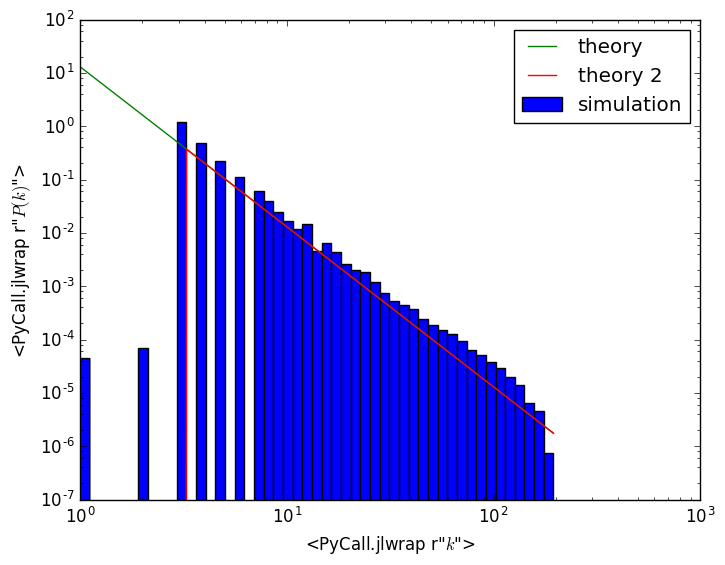

5.991 5.9910000000000005
2000


PyObject <matplotlib.legend.Legend object at 0x31cc01810>

In [104]:
bins=logspace(log10(1),log10(maximum(ks)),50)
# bins=linspace(1,maximum(ks),500)
plt[:hist](ks,bins=bins,log=true,normed=true,label="simulation")
xscale("log")
println(mean(ks)," ",2*m*(1 - m/N))
println(length(vertices(G)))


normalizer = zeta(3) - sum((1.0*collect(1:m-1)).^(-3))

plot(bins,1/normalizer*bins.^-3,label="theory")
p_k = get_p_k_barabasi_albert(k)
plot(bins,[p_k(_) for _ in bins],label="theory 2")
xlabel(r"$k$")
ylabel(r"$P(k)$")
legend()


# collect(bs),hs
# plot(collect(bs),hs)

In [62]:
mean(Cs),k/(N-2)

(0.016862089709613087,0.003003003003003003)

In [33]:

@everywhere begin

k = 4
#y_n = 0.1
c_r = 1.2
N = 10000
n_n = 4000#y_n*N
beta = 4.0/(c_r*n_n)
alpha = (N*beta)/n_n
println(N, ' ' ,alpha, ' ',beta)

im = InfectionModel(x -> 1 + alpha*x , x -> 1 + beta);
imk = InfectionModel(x -> 1 + beta + get_s_eff(x,alpha,beta,k) , x -> 1 + beta);

y_n, y_minus, y_plus, y_p,critical_determinant = get_parameters(N,alpha,beta)
end

10000 0.0020833333333333333 0.0008333333333333334


# Plot Model

## Get Data

In [ ]:
num_trials = 100
num_trials_mixed = 100
fixation_threshold = 1.0#2*y_n
regular=true

sizes_mixedk,num_fixed_mixedk,lengthk,runs_mixedk = 
run_epidemics(num_trials_mixed,imk,(x)
    -> run_epidemic_well_mixed(N,x,fixation_threshold))

@time sizes_mixed,num_fixed_mixed,length,runs_mixed = 
run_epidemics(num_trials_mixed,im,(x)
    -> run_epidemic_well_mixed(N,x,fixation_threshold))

@time sizes_full,num_fixed_full,_,runs_full = 
    run_epidemics(num_trials,im, (x)
-> run_epidemic_graph(N,N-1,x,regular,fixation_threshold))

@time sizes,num_fixed,_,runs = 
    run_epidemics(num_trials,im, (x)
    -> run_epidemic_graph(N,k,x,regular,fixation_threshold))


#sizes,num_fixed,length,runs = run_epidemics(N,num_trials,im, (N,im) -> run_epidemic_graph(N,k,im,regular))


allruns_mixedk = reduce(vcat,runs_mixedk)
allruns_mixed = reduce(vcat,runs_mixed)
allruns_full = reduce(vcat,runs_full)
allruns = reduce(vcat,runs);


In [ ]:
g = LightGraphs.Graph(10)
p = Graph(g,ones(10))
@show set_payload(p,2*ones(10))
p,2*ones(10)
p.payload


## Distribution of Max

In [ ]:

close(5)
figure(5)
bins = logspace(log10(0.1),log10(N),100)
#PyPlot.plt[:hist]([maximum(r) for r in runs],bins=bins,alpha=0.2,normed=true,log=showlog,label="sparse")
PyPlot.plt[:hist]([maximum(r) for r in runs_full],bins=bins,alpha=0.2,normed=true,log=true,label="full")

PyPlot.plt[:hist]([maximum(r) for r in runs_mixed],bins=bins,alpha=0.3,normed=true,log=true,label="mixed")
#PyPlot.plt[:hist]([maximum(r) for r in runs_mixedk],bins=bins,alpha=0.3,normed=true,log=showlog,label="mixed-k")
gca()[:set_xscale]("log")
legend()

## P_fix

In [ ]:
println(num_fixed/num_trials," ", IM.P_fix(imk,N,1/N))

println(num_fixed_full/num_trials," ",IM.P_fix(im,N,1/N))
# println(num_fixed_fullt/num_trials," ",IM.P_fix(im,N,1/N))


println(num_fixed_mixed/num_trials_mixed," ",IM.P_fix(im,N,1/N))

println(num_fixed_mixedk/num_trials_mixed," ",IM.P_fix(imk,N,1/N))


In [ ]:
endrunsfull =[r[end] for r in runs_full] 
endrunsfull[endrunsfull .!= 100.0]
allruns_full_cut = reduce(vcat,runs_full[endrunsfull .!= 100.0])

## Distribution vs. Time

In [ ]:
N = 20
time_arr = zeros(maximum([size(run) for run in runs_mixed])[1],N+1)
for run in runs_mixed
    for (i,val) in enumerate(run[1:end-1])
        time_arr[i,1+round(val)] += 1
    end
    T = size(run)[1]
    if run[T] >= 20
        time_arr[T:end,end] += 1
    elseif run[T] == 0
        time_arr[T:end,1] += 1
    else
        println("Problem")
        println(run[T])
    end
end

for i in 1:size(time_arr)[1]
    time_arr[i,:] /= sum(time_arr[i,:])
end

In [ ]:
using Interact

In [ ]:
f = figure()
@manipulate for i = 1:size(time_arr)[1]
    withfig(f) do
        PyPlot.semilogy(1:20,time_arr[i,:]'+1e-6)
        ylim([1e-7,1])
    end
end

In [ ]:
PyPlot.surf(log10(time_arr[:,2:end-1]+1e-6),rstride=20,cstride=2,alpha=0.4)
PyPlot.gca()[:view_init](elev=30,azim=210)
gca()[:set_xlabel](L"$t$")
gca()[:set_ylabel](L"$x$")
gca()[:set_zlabel](L"$P(x)$")
figure()
plot(time_arr[:,end])
xlabel(L"$t$")
ylabel(L"$P_{fix}(t)$")
figure()
plot(time_arr[:,1])
xlabel(L"$t$")
ylabel(L"$P_{extinct}(t)$")

## General Distribution averaged over time

In [ ]:
close(6)
figure(6)
showlog = true
log_x = false
if log_x
    bins = linspace(log10(0.1),log10(n_n),20)
else
    bins = linspace(0,round(1.1*N),1/2*round(1.1*N))
end    
PyPlot.plt[:hist](allruns_full_cut,bins=bins,alpha=0.2,normed=true,log=showlog,label="full")
PyPlot.plt[:hist](allruns,bins=bins,alpha=0.2,normed=true,log=showlog,label="sparse")
PyPlot.plt[:hist](allruns_mixed,bins=bins,alpha=0.3,normed=true,log=showlog,label="mixed")
PyPlot.plt[:hist](allruns_mixedk,bins=bins,alpha=0.3,normed=true,log=showlog,label="mixed-k")
if log_x
    gca()[:set_xscale]("log")
end
#PyPlot.plt[:hist](allruns_full,bins=linspace(0,n_n,20),alpha=0.2,normed=true,log=true,label="dense")
xlim([0,300])#xlim([0,1.1*N])
legend()

In [ ]:
close("all")

## Distribution of $w$

In [ ]:
figure()
bins = logspace(log10(minimum(sizes_mixed)),log10(maximum(sizes_mixedk)),150)
PyPlot.plt[:hist](sizes,log=true,bins=bins,alpha=0.2,normed=true,label=L"graph, $degree = k$")
PyPlot.plt[:hist](sizes_full,log=true,bins=bins,alpha=0.2,normed=true,label="full")
PyPlot.plt[:hist](sizes_mixedk,log=true,bins=bins,alpha=0.2,normed=true,label=L"mixed, $degree = k$")
PyPlot.plt[:hist](sizes_mixed,log=true,bins=bins,alpha=0.2,normed=true,label=L"mixed, $degree = N-1$")


#PyPlot.plt.hist(sizes_full,log=true,bins=bins,alpha=0.5,normed=true,label="full")
gca()[:set_xscale]("log")

w_range = bins[1:end]#logspace(log10(4*minimum(sizes)),log10(maximum(sizes)),30)

P_w_th_range = normed_distribution(w_range,P_w_th(w_range,s(sqrt(w_range)./N,alpha,beta)))
P_w_th_range_eff = normed_distribution(w_range,P_w_th(w_range,get_s_eff(sqrt(w_range)./N,alpha,beta,k)))

plot(w_range,3*P_w_th_range,"-r",label="theory")#$P(w) \sim e^{- s(\sqrt{w})^2 w/4} w^{-3/2}/(1 + s(\sqrt{w}))$ (theory)')
plot(w_range,3*P_w_th_range_eff,"-g",label="effective theory")#$P(w) \sim e^{- s(\sqrt{w})^2 w/4} w^{-3/2}/(1 + s(\sqrt{w}))$ (theory)')

xlabel(L"w",size=20)
ylabel(L"P(w)",size=20)

legend(loc="lower left")
ylim([1e-8,1e1])
grid()

In [ ]:
bins

# TODO

The probability that an individual is infected
    

## Try to replicate the results of Keelings paper (using clustering coefficient) for our model

## Use gamma-distribution to generate graphs of arbitrary degree distribution. See if results really are independent of variance in k.

## See if we can use equilibration results to get $P(x | \bar{y})$ in the hierarchical network problem

## Derivation of $y_{eff}$: We are picking k not from a binomial distribution, we are sampling *without replacement*!
 - For small $k$ this shouldn't matter
 - For large $k$ we know it should behave just like the well mixed model
 
## For small $k$ and large epidemics, we see differences between the well-mixed model for $k$ and the graph model for $k$. For regular graphs, the fixation probabilities on the graph are lower. These differences go away for large $k$. Maybe this is an effect of locality?
## Account for the variance in $k$ within a graph

## Analyze $N_0 P_{fix}(1/N) = P_{fix}(N_0/N)$?

## Parallelize run_epidemics

## Test whether $y$ overall is equal to $y$ as seen by the susceptibles.

## Compute $P(w)$ for small $w$ to match the experimental results (should be exponential). (Laplace transform from paper, matched asymptotic expansions)

# Random Notes

- It seems that this is because in the well mixed case we are drawing a binomial from the n population,while in the graph case we are attempting to infect the few non-infecteds. We can't get an infectivity greater than all neighbors being infected. But there will always be "deaths" in which an infected becomes uninfected.
- Formulation in terms of random birth + random death (Moran process) vs. formulation in terms of birth and death of type B's (binomial process) vs. formulation in terms of infection spread (graph process).
    
Graph process:
$$b.r. = \sum_{i \in S} n_i/k (1 + \alpha y_i) \sim N(1-y) y (1 + \alpha y)$$
Binomial process:
$$b.r. = N y (1 + \alpha y)$$



In the derivation of $y_{eff}$, how do we deal with $N \to N(1-y)$ in the sum? -> That $y$ is the $y$ of the overall graph, it just carries through the derivation.

How do we plot probability distribution over time? Can bin/smooth in both position or time space.



Tunable constraint model:
- not necessarily constant population size

Conditional models:
- some models can diverge, condition on them staying well-behaved

In [ ]:
close("all")

## Parallelization

In [ ]:
#addprocs(2)
using SIS,IM,PayloadGraph,PyPlot,Epidemics
nprocs()

In [ ]:
@everywhere using IM

In [ ]:
addprocs(2)
nprocs()
@everywhere using SIS, IM, PayloadGraph,Epidemics

In [ ]:
num_runs = num_trials
ss = @spawn run_epidemic_graph(N,k,im,regular,fixation_threshold)
fetch(ss)

In [ ]:
@everywhere begin

num_trials = 10
fixation_threshold = 2*y_n
regular=true
    
end

srand(1)
@time sizes,num_fixed,_,runs = 
    run_epidemics(N,num_trials,im, (N,im)
    -> run_epidemic_graph(N,k,im,regular,fixation_threshold));

@show sum(sizes)

srand(1)
@time sizes,num_fixed,_,runs = 
run_epidemics_parallel(N,num_trials,im, (N,im)
    -> run_epidemic_graph(N,k,im,regular,fixation_threshold));

@show sum(sizes)

## Speed Scaling

In [ ]:
function cat_parallel(N)
    @parallel (vcat) for i = 1:N
        [1]
    end
end

function cat_serial(N)
    return reduce(vcat)
    cat::Array{Int} = []
    for i = 1:N
        cat = vcat(cat,[1])
    end
    cat
end

function pm(N,m)
    return pmap(_ -> sum(randn(m,m)^2),1:N)
end

function sm(N,m)
    return map(_ -> sum(randn(m,m)^2),1:N)
end

In [ ]:
N = 10
@time pm(N);
@time sm(N);
#sp == ss
#(sp - ss)/ss

In [ ]:
num_trials = 100
#sizes_full,num_fixed_full,_,runs_full = run_epidemics(N,N-1,num_trials,im)

#@time run_epidemics(N,k,num_trials,im);

xx = [10,20,40,80,160]
yy = [0.035,0.085,0.31,1.01,2.8]
#yy = [0.03,0.08,0.3,1.0,3.3] #for k = 4 = const
#yy = [0.06,0.3,1.7,12] for fully connected

loglog(xx,yy)
loglog(xx,0.0005*xx.^1.7)
xlim([4,400])
grid()

#x^2.5 for fully connected graph
#x^1.7 for constant connected graph k = 4
#x^1.6 for constant connected graph k = 8
log(yy[end]/yy[1])/log(xx[end]/xx[1])